In [34]:
# Pandas умеет читать excel-файлы по листам, используем его для вывода первых строк
# и экспорта csv для SQL
# Не забываем поставить пакет openpyxl
import pandas

transaction = pandas.read_excel('customer_and_transaction.xlsx', sheet_name='transaction')
# Удаляем некорректные значения
transaction.dropna(how='any', inplace=True)
transaction=transaction[transaction['customer_id'] != 5034]
transaction.to_csv("transaction.csv", index=None, sep=';')
customer = pandas.read_excel('customer_and_transaction.xlsx', sheet_name='customer')
customer.to_csv("customer.csv", index=None, sep=';')
display(transaction.head())
display(customer.head())

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48


,customer_id,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,F,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,Eli,Bockman,Male,1980-12-16 00:00:00,Administrative Officer,Financial Services,Mass Customer,N,Yes,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,3,Arlin,Dearle,Male,1954-01-20 00:00:00,Recruiting Manager,Property,Mass Customer,N,Yes,0 Holy Cross Court,4211,QLD,Australia,9
3,4,Talbot,NaN,Male,1961-10-03 00:00:00,NaN,IT,Mass Customer,N,No,17979 Del Mar Point,2448,New South Wales,Australia,4
4,5,Sheila-kathryn,Calton,Female,1977-05-13 00:00:00,Senior Editor,NaN,Affluent Customer,N,Yes,9 Oakridge Court,3216,VIC,Australia,9


* Обе изначальные таблицы (`transaction` и `customer`) соответствуют 1НФ и 2НФ.
* Таблица `transatction` не соответствует 3НФ, так как имеет транзитивные аттрибуты (`brand`, `product_line`, `product_class`, `product_size`, `list_price`, `standard_cost` зависят от `product_id`).
* Таблица `customer` не соответствует 3НФ, так как имеет транзитивные аттрибуты (`postcode`, `state`, `country` могут быть зависимы друг от друга).

Новая схема (графически, в `dbdiagram.io`):

```sql
Table address {
  id INT [pk, increment]
  postcode INT [not null]
  state varchar [not null]
  country varchar [not null]
  address_line varchar [not null]
  Indexes {
    (postcode, state, country, address_line) [unique, name: 'unique_address']
  }
}

Table customer {
  id INT [pk]
  first_name varchar [not null]
  last_name varchar
  gender varchar [not null]
  DOB DATE [not null]
  job_title varchar
  job_industry_category varchar
  wealth_segment varchar [not null]
  deceased_indicator varchar [not null]
  owns_car varchar [not null]
  address_id INT [not null]
  property_valuation INT [not null]
}

Table product {
  id INT [pk]
  brand varchar [not null]
  product_line varchar [not null]
  product_class varchar [not null]
  product_size varchar [not null]
  list_price DECIMAL(10, 2) [not null]
  standard_cost DECIMAL(10, 2) [not null]
}

Table transaction {
  id INT [pk]
  product_id INT [not null]
  customer_id INT [not null]
  transaction_date DATE [not null]
  online_order BOOLEAN [not null]
  order_status varchar [not null]
}

ref: customer.address_id > address.id
ref: transaction.product_id > product.id
ref: transaction.customer_id > customer.id
```

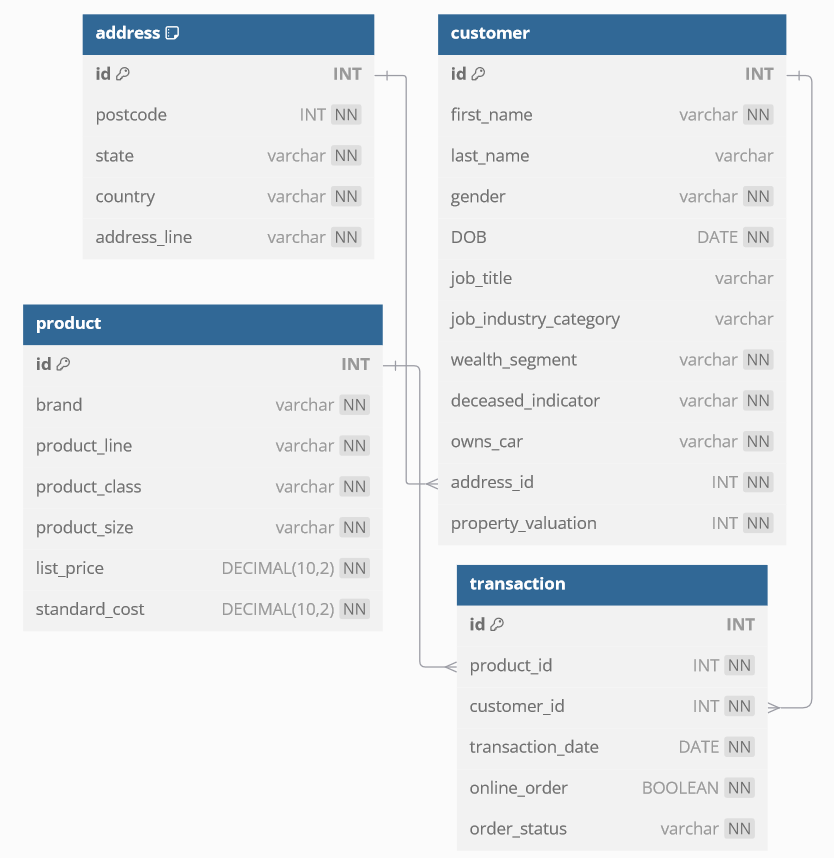

Команды создания таблиц и импорта данных:
```sql
--- Создание таблиц
CREATE TABLE product (
    id SERIAL PRIMARY KEY,
    brand VARCHAR(255),
    product_line VARCHAR(50) NOT NULL,
    product_class VARCHAR(50) NOT NULL,
    product_size VARCHAR(50) NOT NULL,
    list_price DECIMAL(10, 2) NOT NULL,
    standard_cost DECIMAL(10, 2) NOT NULL
);

CREATE TABLE address (
    id SERIAL PRIMARY KEY,
    postcode VARCHAR(10) NOT NULL,
    state VARCHAR(50) NOT NULL,
    country VARCHAR(50) NOT NULL,
    address VARCHAR(255),
    -- Только уникальные значения
    CONSTRAINT unique_address UNIQUE (postcode, state, country, address)
);

CREATE TABLE customer (
    id SERIAL PRIMARY KEY,
    first_name VARCHAR(50) NOT NULL,
    last_name VARCHAR(50),
    gender VARCHAR(10) NOT NULL,
    DOB DATE,
    job_title VARCHAR(100),
    job_industry_category VARCHAR(50),
    wealth_segment VARCHAR(50) NOT NULL,
    deceased_indicator CHAR(1) NOT NULL,
    owns_car VARCHAR(3) NOT NULL,
    address_id INT NOT NULL,
    property_valuation INT NOT NULL,
    FOREIGN KEY (address_id) REFERENCES address(id)
);

CREATE TABLE transaction (
    id SERIAL PRIMARY KEY,
    product_id INT NOT NULL,
    customer_id INT NOT NULL,
    transaction_date DATE NOT NULL,
    online_order BOOLEAN NOT NULL,
    order_status VARCHAR(50) NOT NULL,
    FOREIGN KEY (product_id) REFERENCES product(id),
    FOREIGN KEY (customer_id) REFERENCES customer(id)
);

--- Импорт данных
--- Создаём и заполняем временную таблицу
CREATE TEMP TABLE temp_customer (
    customer_id INT,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    gender VARCHAR(10),
    DOB DATE,
    job_title VARCHAR(100),
    job_industry_category VARCHAR(50),
    wealth_segment VARCHAR(50),
    deceased_indicator CHAR(1),
    owns_car VARCHAR(3),
    postcode VARCHAR(10),
    state VARCHAR(50),
    country VARCHAR(50),
    address VARCHAR(255),
    property_valuation INT,
	address_id INT
);
COPY temp_customer(customer_id, first_name, last_name, gender, DOB,
                    job_title, job_industry_category, wealth_segment,
                    deceased_indicator, owns_car, address, postcode,
                    state, country, property_valuation)
FROM '/customer.csv' DELIMITER ';' CSV HEADER;
--- Заполняем address
INSERT INTO address (postcode, state, country, address)
SELECT DISTINCT postcode, state, country, address
FROM temp_customer ON CONFLICT DO NOTHING;
--- Устанавливаем address_id
UPDATE temp_customer as tc
SET address_id = a.id
FROM address as a
WHERE tc.postcode = a.postcode
AND tc.state = a.state
AND tc.country = a.country
AND (tc.address = a.address OR (tc.address IS NULL AND a.address IS NULL));
--- Заполняем customer
INSERT INTO customer(id, first_name, last_name, gender, DOB, job_title, 
                      job_industry_category, wealth_segment, deceased_indicator, 
                      owns_car, address_id, property_valuation)
SELECT customer_id, first_name, last_name, gender, DOB, job_title, 
       job_industry_category, wealth_segment, deceased_indicator, 
       owns_car, address_id, property_valuation
FROM temp_customer;
--- Удаляем временную таблицу temp_customer;
DROP TABLE temp_customer;
--- Создаём и заполняем временную таблицу
CREATE TEMP TABLE temp_transaction (
    transaction_id INT,
    product_id INT,
    customer_id INT,
    transaction_date DATE,
    online_order BOOLEAN,
    order_status VARCHAR(50),
    brand VARCHAR(255),
    product_line VARCHAR(50),
    product_class VARCHAR(50),
    product_size VARCHAR(50),
    list_price DECIMAL(10, 2),
    standard_cost DECIMAL(10, 2)
);
COPY temp_transaction(transaction_id,product_id,customer_id,transaction_date,
                        online_order,order_status,brand,product_line,product_class,
                        product_size,list_price,standard_cost)
FROM '/transaction.csv' DELIMITER ';' CSV HEADER;
--- Заполняем product
INSERT INTO product (id, brand, product_line, product_class, product_size, list_price, standard_cost)
SELECT DISTINCT product_id, brand, product_line, product_class, product_size, list_price, standard_cost
FROM temp_transaction ON CONFLICT DO NOTHING;
--- Заполняем transaction
INSERT INTO transaction(id, product_id, customer_id, transaction_date,
                        online_order, order_status)
SELECT transaction_id, product_id, customer_id, transaction_date,
        online_order, order_status
FROM temp_transaction;
--- Удаляем временную таблицу temp_transaction;
DROP TABLE temp_transaction;
```

Скриншоты из `dbeaver`:

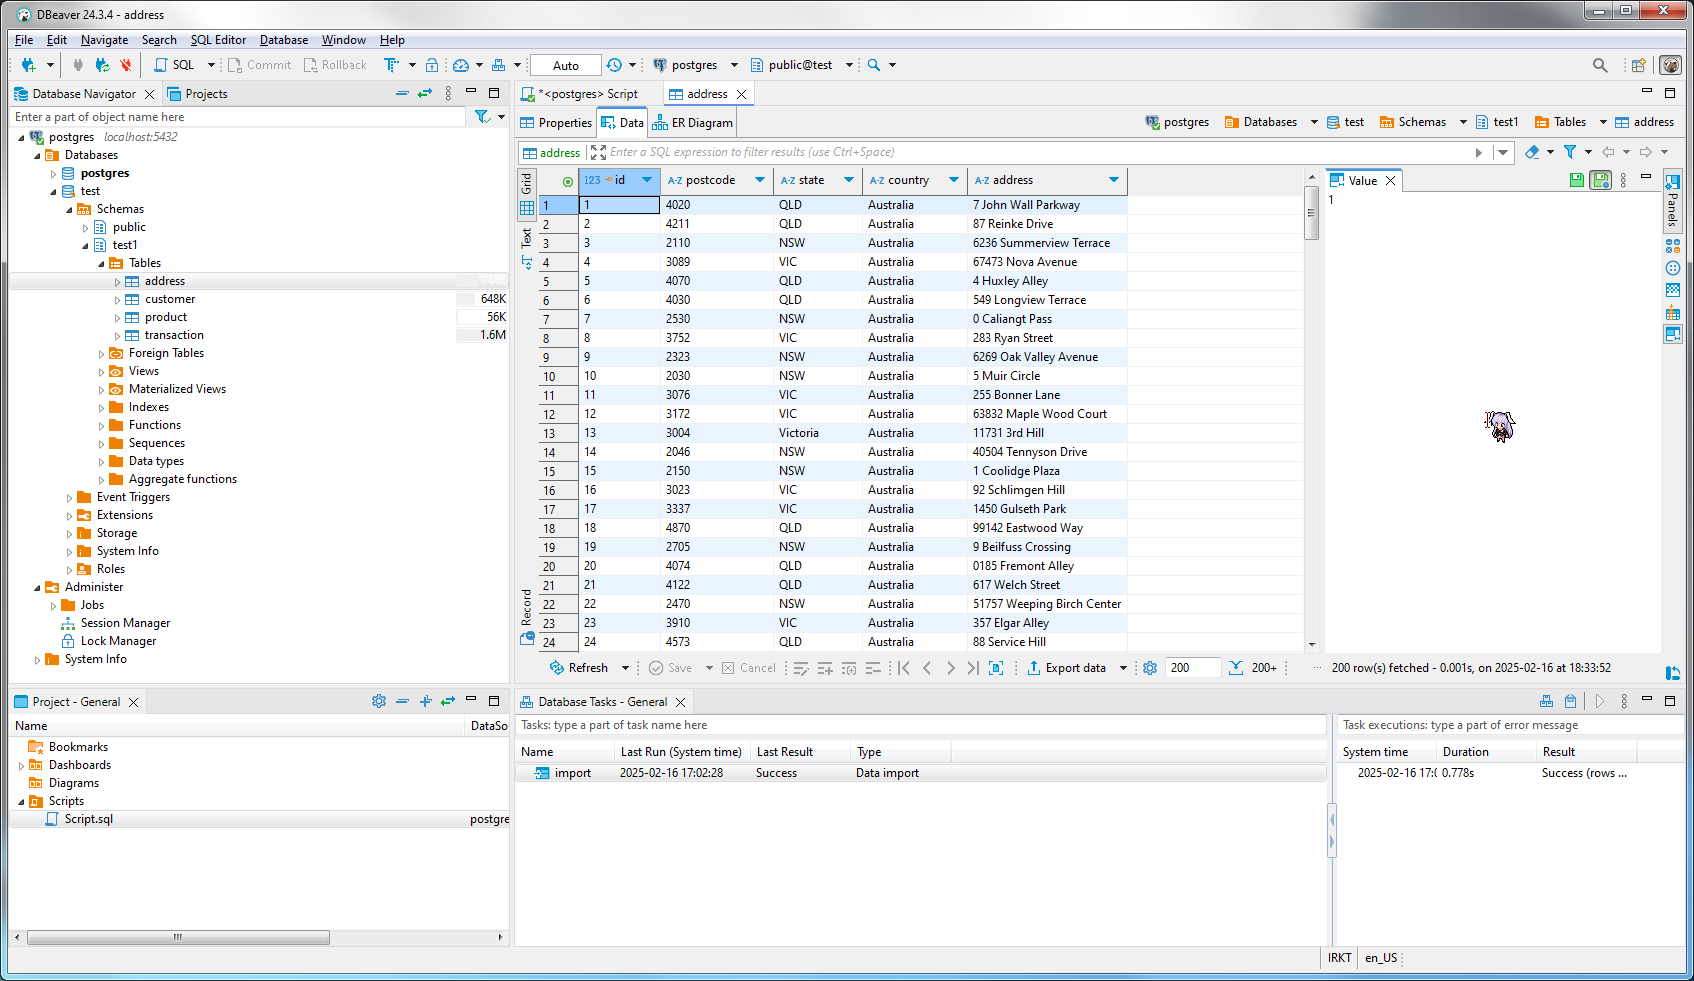
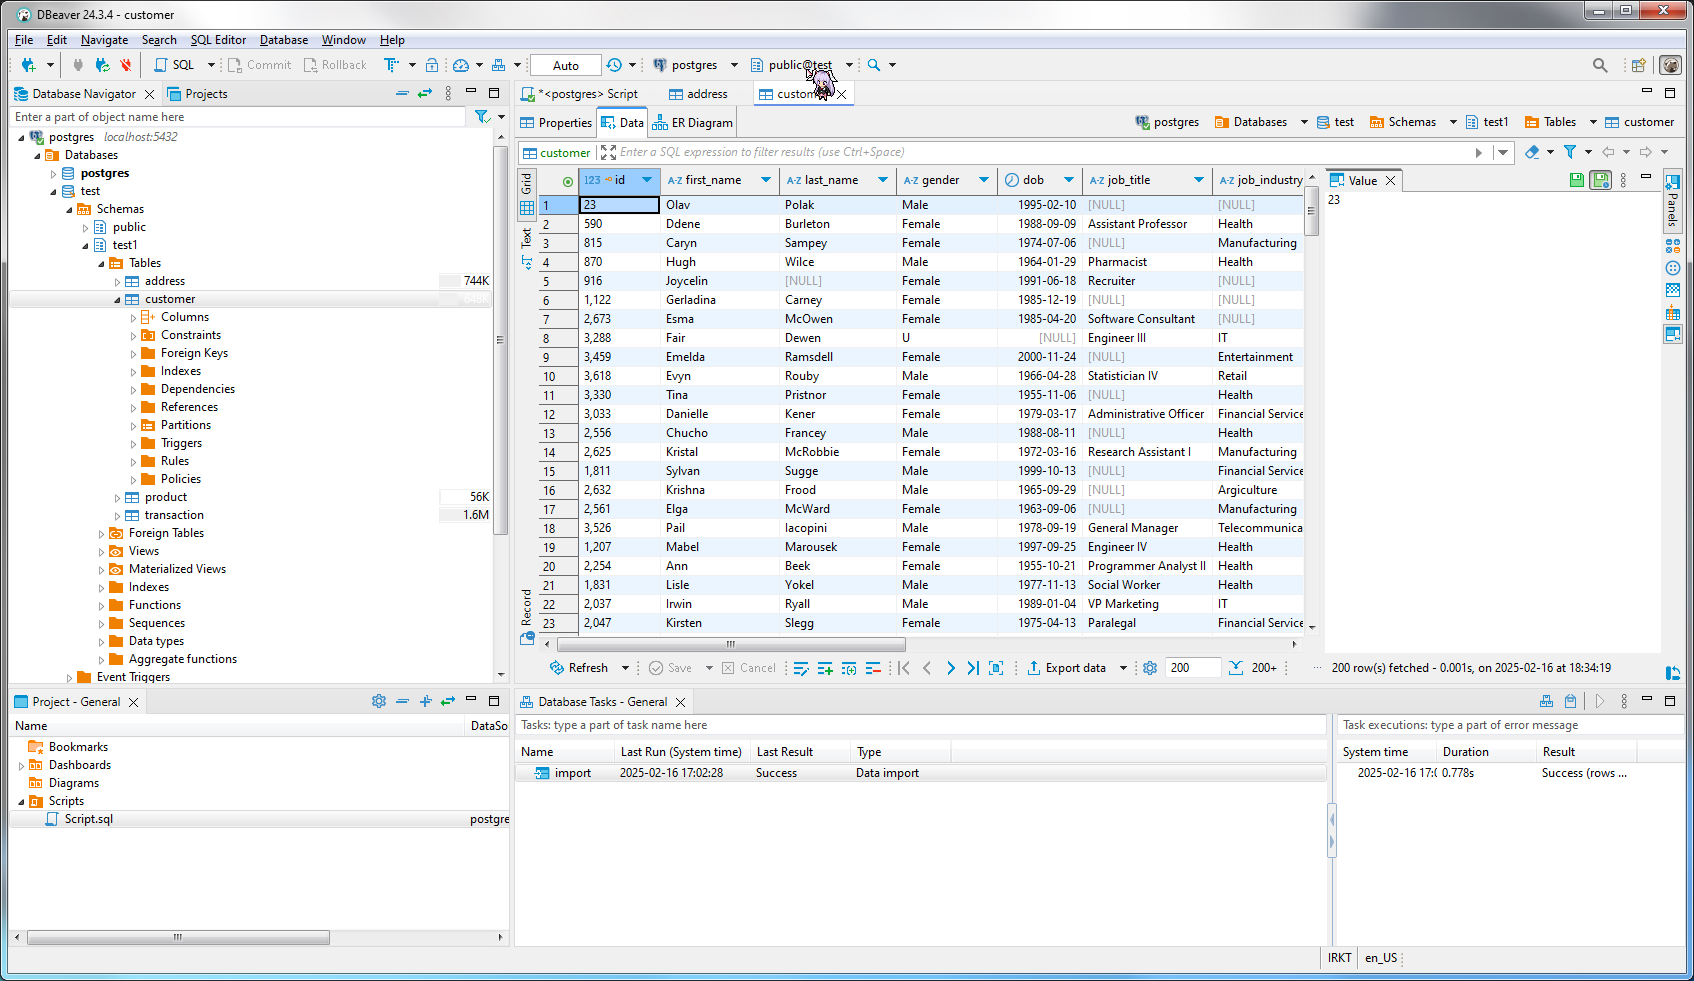
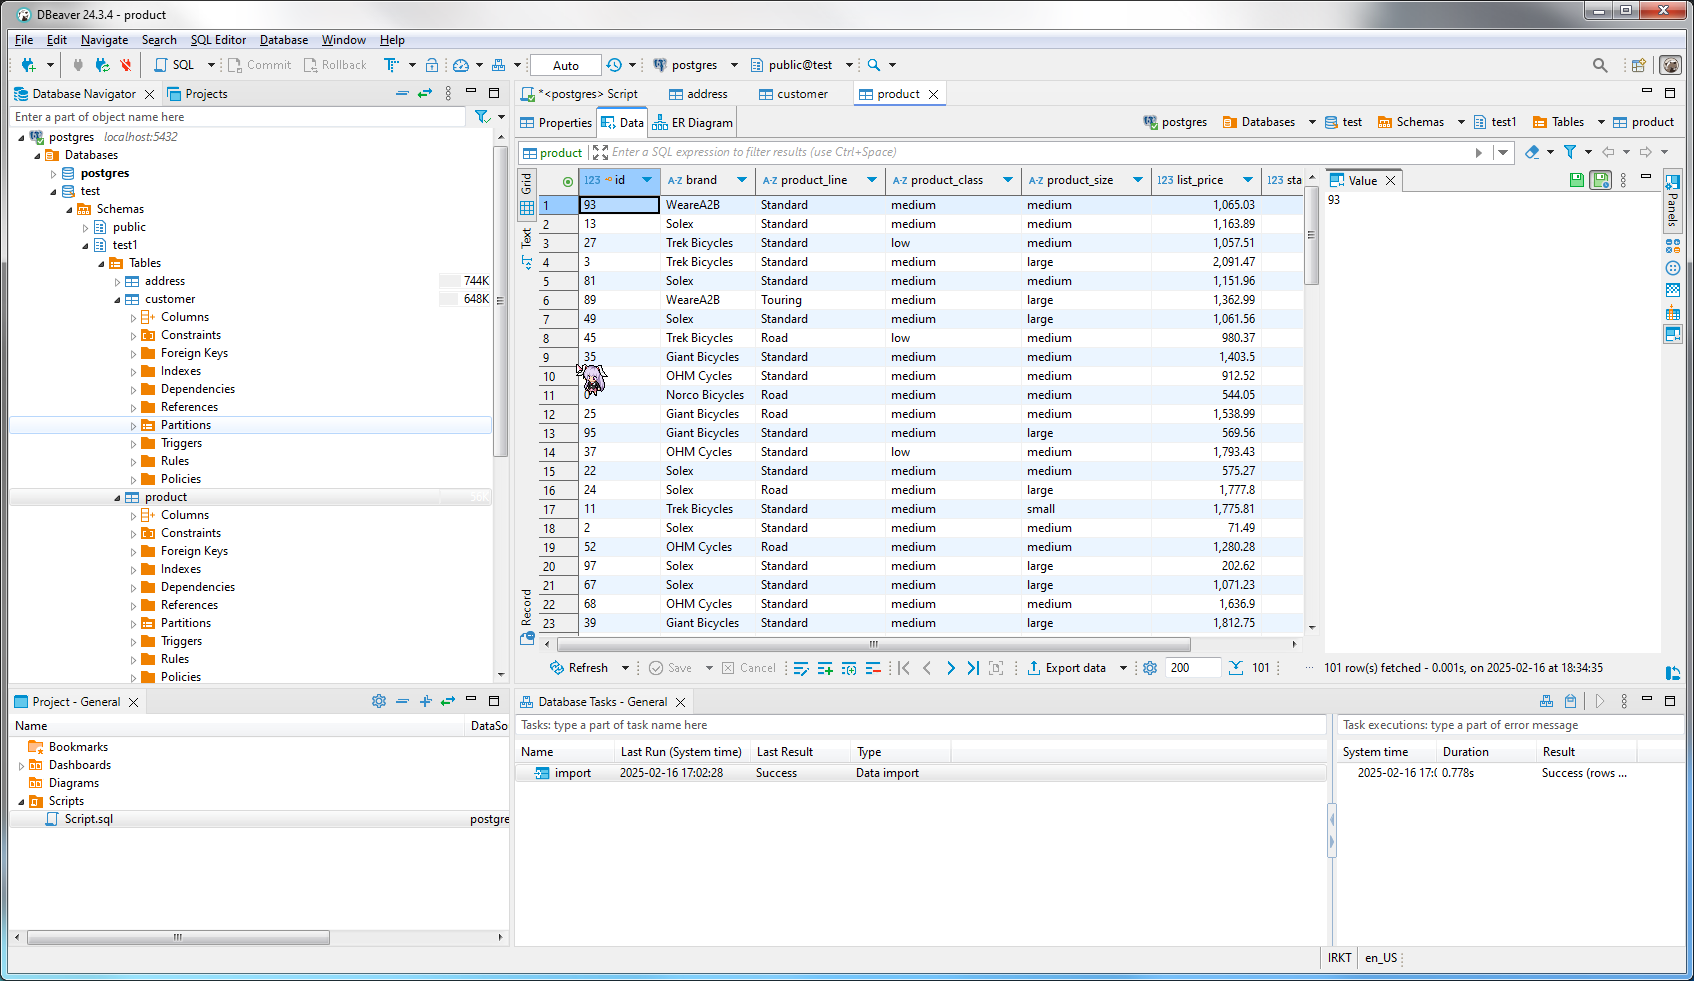
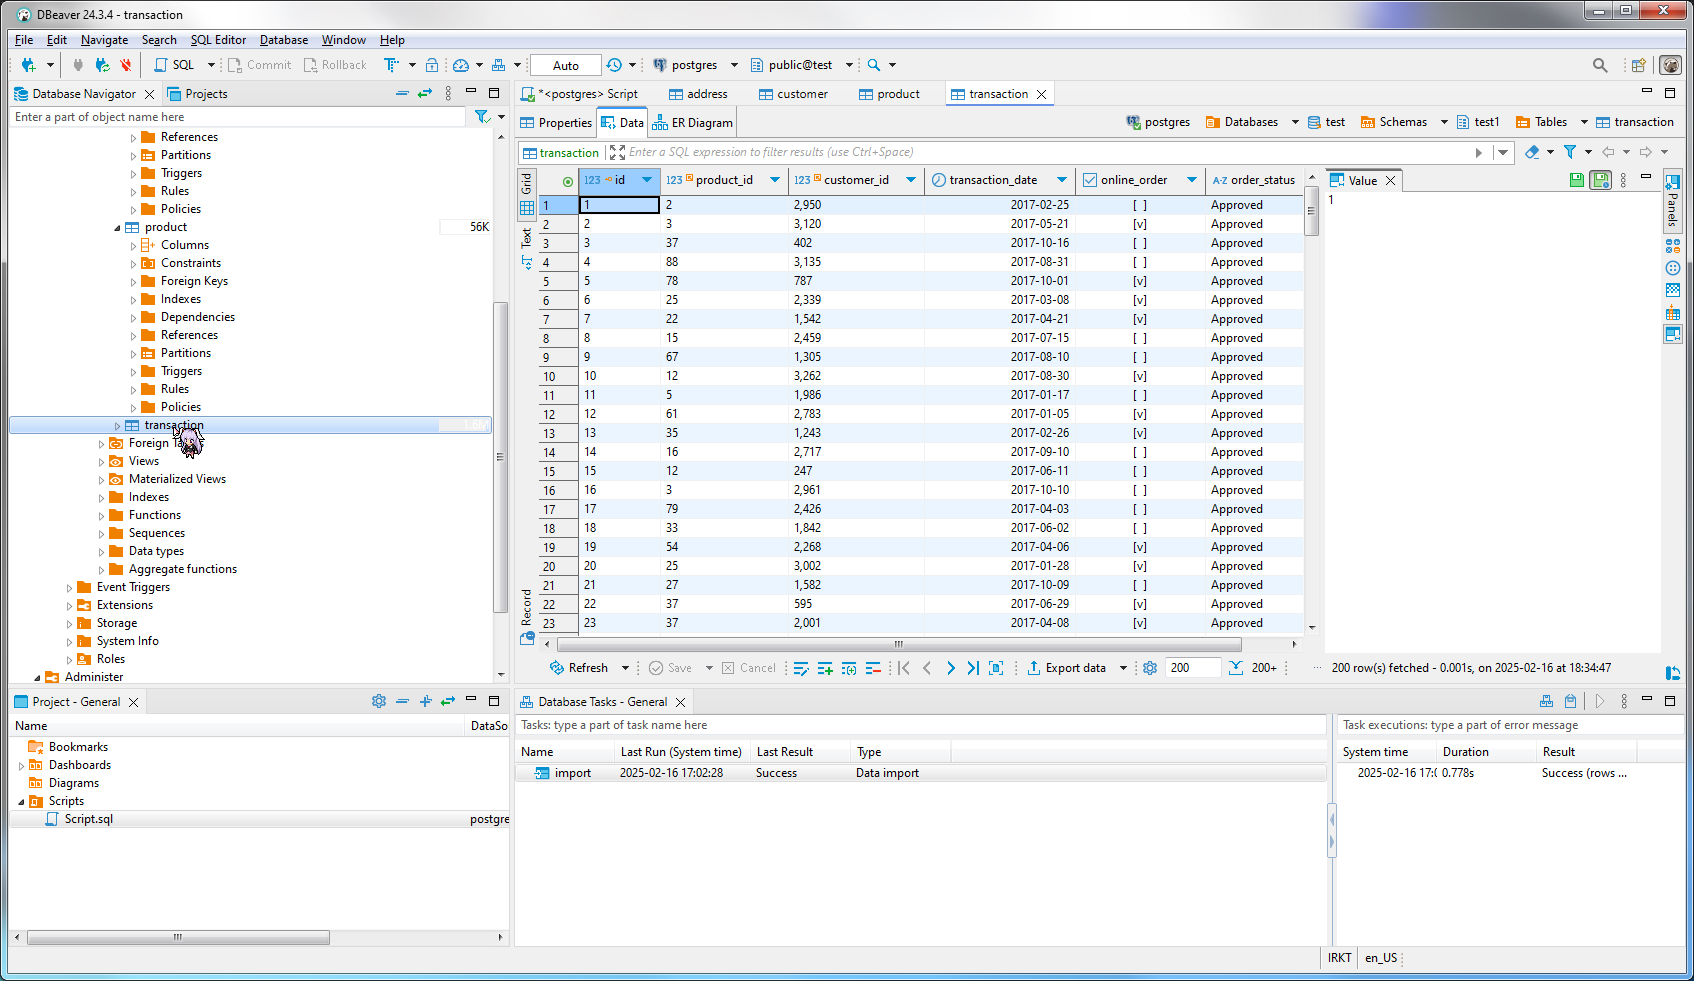